# *Model Selection and Regularization* (Seleção de Modelos e Regularização)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Seleção de Variáveis por Subconjuntos
  * Melhor Seleção de Subconjunto
  * Forward Stepwise Selection (Seleção passo a passo para frente)
  * Backward Stepwise Selection (Seleção passo a passo para trás)
  * Escolhendo o modelo ideal
  * Validação e Validação Cruzada
* Shrinkage Methods (Métodos de Encolhimento)
  * Ridge Regression (L2)
  * Trade-off de viés-variância
  * Lasso (L1)
  * Comparando a regressão Lasso e Ridge
  * Selecionando o parâmetro de ajuste
  * Elastic Net
  * Como escolher na prática?
* Seleção de Variáveis Clássica vs Regularização


### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 6***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman
* Notas próprias.


***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

### 1. Introdução

***Na era do big data***, não enfrentamos apenas o desafio de trabalhar com conjuntos de dados com um grande número de observações (ou amostras), normalmente representado pela letra $n$. Muitas vezes, também lidamos com um número muito elevado de variáveis explicativas ou preditores, que vamos denotar por $p$.

Por exemplo, imagine um estudo com $n = 100$ indivíduos, para os quais coletamos $p = 10$ variáveis, como idade, peso, altura, escolaridade, entre outras. Nesse caso, temos uma situação tradicional, onde o número de variáveis ($p$) é bem menor do que o número de observações ($n$). Esse cenário é confortável para a aplicação de OLS.

Entretanto, com a crescente disponibilidade de dados, é cada vez mais comum nos depararmos com situações onde o número de variáveis é muito grande, às vezes até maior do que o número de observações (por exemplo, $p = 10.000$ variáveis para apenas $n = 100$ indivíduos). Nesses casos, surgem sérios desafios:

- Quando $p > n$, o modelo OLS **não pode ser ajustado** da forma usual, pois o sistema de equações possui infinitas soluções.
- Mesmo quando $p < n$, incluir muitas variáveis pode levar a problemas como o **sobreajuste** (**overfitting**) e **multicolinearidade**, prejudicando a capacidade de generalização do modelo.

Além disso, muitas vezes nos interessa construir um modelo **parcimonioso**, que utilize apenas um subconjunto de variáveis relevantes, que chamaremos de $k$. Em geral, buscamos que esse número $k$ de variáveis efetivamente incluídas no modelo seja **muito menor** do que o total disponível: $k \ll p$, e claro, $k < n$. 

>
>Esse processo de ***identificar e selecionar as variáveis mais importantes*** é conhecido como **seleção de variáveis**.
>

Diante desses desafios, surgem técnicas de **seleção de modelos** e **regularização**, cujo objetivo é:

- Permitir a modelagem mesmo quando $p$ é grande em relação a $n$;
- Evitar o sobreajuste;
- Melhorar a capacidade de previsão;
- Produzir modelos mais interpretáveis.

Nesta aula, abordaremos as principais abordagens para lidar com esses problemas, incluindo:

- **Seleção de variáveis por subconjuntos**;
- **Métodos de regularização**, como Ridge, Lasso e Elastic Net;

Nosso foco será entender não apenas como aplicar essas técnicas, mas também quando e por que elas são necessárias, especialmente em cenários de **alta dimensionalidade**.

Carregando as bibliotecas necessárias para os exempls de aula, e definição das plotagens:

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import pandas as pd
import numpy as np
import time
import itertools
import statsmodels.api as sm
import seaborn as sns

from numpy.random import normal, uniform
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (8,3)
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

### 2. Seleção de Variáveis por Subconjuntos

A abordagem de **seleção de variáveis por subconjuntos** envolve a identificação de um subconjunto dentre os $p$ preditores disponíveis, que acreditamos estar relacionados à variável resposta. Em seguida, ajustamos um modelo utilizando mínimos quadrados apenas com esse conjunto reduzido de variáveis.

Vamos carregar o banco de dados e chamá-lo de `credit`.

In [3]:
# Credit ratings dataset
credit = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Credit.csv', usecols=list(range(1,12)))
credit

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
396,13.364,3838,296,5,65,17,Male,No,No,African American,480
397,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
398,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0


Vamos analisar a relação entre ***características individuais*** e `Balance` da conta no conjunto de dados `Credit`.

In [4]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

In [5]:
X

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian
2,104.593,7075,514,4,71,11,Male,No,No,Asian
3,148.924,9504,681,3,36,11,Female,No,No,Asian
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian
396,13.364,3838,296,5,65,17,Male,No,No,African American
397,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian
398,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian


In [6]:
y

0      333
1      903
2      580
3      964
4      331
      ... 
395    560
396    480
397    138
398      0
399    966
Name: Balance, Length: 400, dtype: int64

### 2.1. Melhor Seleção de Subconjunto

A **melhor seleção de subconjunto** consiste em ajustar uma regressão de mínimos quadrados separada para **cada combinação possível** de preditores. Ou seja, ajustamos:

- todos os modelos que contêm exatamente um preditor;
- todos os modelos que contêm exatamente dois preditores;
- e assim por diante, até considerar o modelo com todos os preditores.

Em seguida, comparamos todos os modelos resultantes, com o objetivo de identificar aquele que apresenta o melhor desempenho segundo algum critério (como $R^2$, RSS, BIC, ou AIC).

**Claramente, a principal desvantagem da melhor seleção de subconjunto é o seu elevado custo computacional**, especialmente quando o número de preditores $p$ é grande, pois o número de modelos possíveis cresce exponencialmente com $p$.

* O total de modelos possíveis é dado por $2^p$, considerando o modelo nulo (sem preditores).
* As combinações de $k$ preditores dentre os $p$ disponíveis é dada por $\binom{p}{k} = \frac{p!}{k!(p-k)!}$.


A seguir, apresentamos uma função que implementa essa abordagem em Python, permitindo avaliar diferentes combinações de variáveis de acordo com múltiplas métricas. Ou seja, o código gera todas as combinações possíveis de $k$ variáveis entre as $K$ disponíveis. Por exemplo:
* Se $K=3$, o total de combinações possíveis é $2^3 = 8$. Seguindo a ideia da busca por subconjuntos, começamos estimando com o modelo nulo (sem variáveis, $k=0$) e vamos até o modelo completo (com todas as variáveis, $k=3$). 
* Por exemplo, considerando a rodada de análise com apenas $k=2$ (modelo considerado com 2 variáveis), teríamos as combinações $\binom{3}{2} = \frac{3!}{2!(3-2)!} = 3$, ou seja, (var1, var2), (var1, var3), (var2, var3).
* Então, o código vai ajustar uma regressão para cada combinação possível. E depois verifica-se as métricas de desempenho dos modelos.


In [7]:
def model_selection(X, y, *args):
    """
    Função para seleção de modelo avaliando diferentes combinações de variáveis.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - *args: funções que recebem um modelo ajustado e retornam um score (e.g., RSS, R²).

    Retorno:
    - Lista de arrays, cada um com colunas: [número de variáveis, valor da métrica]
    """
    
    # Inicializa listas para armazenar os scores
    scores = list(itertools.repeat(np.zeros((0, 2)), len(args)))

    # Variáveis categóricas a serem convertidas em dummies
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Número total de variáveis
    K = np.shape(X)[1]

    # Loop sobre o número de variáveis a serem incluídas (de 0 até K)
    for k in range(K + 1):
        print(f"Computing k={k}", end="")

        # Todas as combinações possíveis de k variáveis
        for i in combinations(range(K), k):

            # Subconjunto de variáveis
            X_subset = X.iloc[:, list(i)].copy()

            # Tratamento de variáveis categóricas
            if k > 0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float para evitar erro no statsmodels
            if k > 0:
                X_subset = X_subset.astype(float)
            
            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add') if k > 0 else np.ones((len(y), 1))

            # Ajusta modelo
            reg = OLS(y, X_reg).fit()

            # Calcula e armazena as métricas
            for j, metric in enumerate(args):
                score = np.reshape([k, metric(reg)], (1, -1))
                scores[j] = np.append(scores[j], score, axis=0)
        
        print("", end="\r")

    return scores

Vamos considerar, neste exemplo, 10 variáveis explicativas (É o que temos no dataframe $X$, logo, $p=10$) e duas métricas de avaliação para a seleção de modelos:

- **Soma dos Quadrados dos Resíduos** (RSS — *Residual Sum of Squares*), que mede o erro de ajuste.
- **Coeficiente de Determinação** ($R^2$), que mede a proporção da variabilidade da resposta explicada pelo modelo.

A seguir, definimos essas métricas como funções e utilizamos a função `model_selection` para calcular as pontuações de todos os modelos possíveis.

In [8]:
# Métricas selecionadas
rss = lambda reg : reg.ssr
r2 = lambda reg : reg.rsquared

# Compute scores
scores = model_selection(X, y, rss, r2)
ms_RSS = scores[0]
ms_R2 = scores[1]

* função `lambda`, cria uma função que:
  * Recebe argumentos ("reg")
  * Retorna o valor da expressão ("reg.ssr", ou "reg.rsquared")

A função `model_selection`
* Gera todos os subconjuntos possíveis de preditores (de 0 até K variáveis).
* Para cada subconjunto, ajusta um modelo de regressão OLS com `statsmodels`.
* Para cada modelo ajustado, aplica:
  * rss(modelo) → extrai o RSS.
  * r2(modelo) → extrai o R².
* Guarda o resultado:
  * O número de variáveis (k).
  * O valor da métrica (rss ou r2).
* No fim, `model_selection` retorna:
  * Uma lista com dois arrays.
    * scores[0]: array com todos os resultados da métrica RSS.
    * scores[1]: array com todos os resultados da métrica R².

In [9]:
# Save best scores
K = np.shape(X)[1]
ms_RSS_best = [np.min(ms_RSS[ms_RSS[:,0]==k,1]) for k in range(K+1)]
ms_R2_best = [np.max(ms_R2[ms_R2[:,0]==k,1]) for k in range(K+1)]

* `ms_RSS_best` é uma lista com $K+1$ elementos. Cada elemento contém o menor RSS obtido entre todos os modelos que possuem exatamente $k$ variáveis.
* `ms_R2_best` é uma lista com K+1 elementos. Cada elemento contém o maior $R^{2}$ obtido entre todos os modelos que possuem exatamente k variáveis.
* Em resumo: está pegando o melhor modelo em termos dessas métricas, para cada tamanho de modelo (k). 
 

***Por exemplo:***

Com 3 variáveis (K), teremos o numero total de modelos possíveis: $2^3 = 8$. Para K=0, temos apenas o modelo nulo (sem variáveis), para k=1, temos 3 modelos (cada um com uma variável), para k=2, temos 3 modelos (cada um com duas variáveis) e para k=3, temos apenas 1 modelo (com as 3 variáveis). vejamos:

| k | RSS |
|--|-|
|0	|500|
|1	|300|
|1	|280|
|1	|350|
|2	|200|
|2	|190|
|2	|210|
|3	|180|

* Para k=1, os RSS são: 300, 280, 350 
  * mínimo = 280
* Para k=2, os RSS são: 210, 200, 190 
  * mínimo = 190

Resultado é `ms_RSS_best` = [500, 280, 190, 180], temos o vetor com os $K+1$ elementos.

Vamos traçar as melhores pontuações.

In [10]:
# Figure 6.1
def make_figure_6_1():

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.1: Best Model Selection')

    # RSS
    ax1.scatter(x=ms_RSS[:,0], y=ms_RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1), ms_RSS_best, c='r');
    ax1.scatter(np.argmin(ms_RSS_best), np.min(ms_RSS_best), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.scatter(x=ms_R2[:,0], y=ms_R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_R2_best, c='r');
    ax2.scatter(np.argmax(ms_R2_best), np.max(ms_R2_best), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

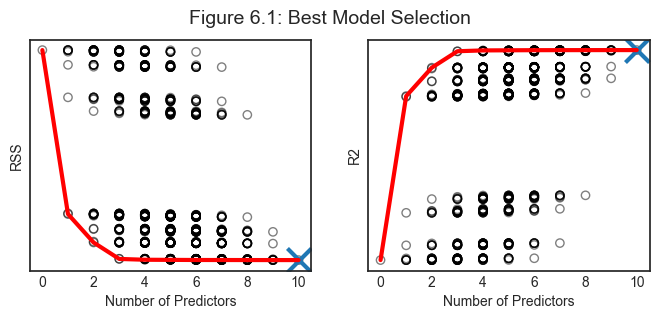

In [11]:
make_figure_6_1()

A figura mostra que, como esperado, ambas as métricas — o RSS e o $R^2$ — melhoram à medida que o número de variáveis aumenta. No entanto, a partir do modelo com **três variáveis**, observa-se que há **pouca melhoria adicional** no RSS e no $R^2$ com a inclusão de novos preditores.

Esse comportamento é típico: modelos mais complexos tendem a ajustar melhor os dados, mas com **ganhos marginais** à medida que mais variáveis são adicionadas, além de aumentarem o risco de **sobreajuste**. Assim, a seleção do modelo ideal deve balancear a qualidade do ajuste com a simplicidade e a interpretabilidade.


***Podemos concluir que o procedimento faz sentido, entretanto é computacionalmente intensivo, especialmente quando o número de variáveis é grande. Então, seguimos nossa busca pelo modelo ideal através da busca de métodos mais eficientes.***

### 2.2. *Forward Stepwise Selection* (seleção progressiva passo a passo)

Enquanto a melhor seleção de variáveis por subconjunto considera **todos os modelos possíveis** formados a partir dos $p$ preditores, a **seleção progressiva passo a passo** (*forward stepwise selection*) ***avalia um número muito menor de modelos, o que a torna uma alternativa mais viável computacionalmente***.

Esse procedimento segue a seguinte lógica:

1. Começa com o **modelo nulo**, que contém **apenas o intercepto**, sem nenhum preditor.
2. Em cada passo, **avalia-se a inclusão de cada uma das variáveis ainda não incluídas** no modelo.
3. A variável que proporciona a **maior melhoria adicional** no ajuste — segundo algum **critério de seleção** (como $ R^2$ ajustado, AIC, BIC ou RSS) — é **adicionada** ao modelo.
4. O processo continua, **adicionando uma variável por vez**, até que todas as variáveis estejam incluídas ou até que algum **critério de parada** seja satisfeito.

Esse tipo de abordagem é considerado uma **estratégia gulosa** (*greedy*), pois faz **escolhas locais** — em cada etapa, seleciona a variável que **parece melhorar mais** o ajuste naquele momento, sem considerar o efeito **global** de todas as combinações.

Assim, a *forward stepwise selection* busca construir um modelo **parcimonioso e eficiente**, evitando o **custo computacional** de avaliar todas as combinações possíveis de preditores.

A seguir, implementamos o procedimento de **seleção progressiva passo a passo** (*forward selection*), que adiciona uma variável de cada vez, sempre escolhendo aquela que minimiza a função de avaliação especificada (por exemplo, a Soma dos Resíduos dos Quadrados - RSS).

In [12]:
def forward_selection(X, y, f):
    """
    Forward selection: adiciona uma variável de cada vez, escolhendo a que minimiza a função f.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - f: função de avaliação do modelo (e.g., RSS).

    Retorno:
    - fms_scores: vetor com os melhores scores em cada passo.
    """
    
    # Inicializa RSS
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))

    # Variáveis categóricas
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Lista de variáveis selecionadas
    selected_cols = []

    for k in range(1, K + 1):
        remaining_cols = [col for col in X.columns if col not in selected_cols]
        temp_scores = np.zeros((0,1))

        for col in remaining_cols:
            # Subset das variáveis
            X_subset = X.loc[:, selected_cols + [col]].copy()

            # Dummy encoding para categóricas
            categ_subset = list(categ_cols & set(X_subset.columns))
            if categ_subset:
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float
            X_subset = X_subset.astype(float)

            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add')

            # Regressão
            reg = OLS(y, X_reg).fit()

            # Avaliação
            temp_scores = np.append(temp_scores, f(reg))

        # Seleciona a melhor variável
        best_col = remaining_cols[np.argmin(temp_scores)]
        print(f"Selecionada: {best_col}")
        selected_cols += [best_col]
        fms_scores[k - 1] = np.min(temp_scores)

    return fms_scores

Agora, vamos selecionar o melhor modelo utilizando a Soma dos Resíduos dos Quadrados (RSS) como métrica:

In [13]:
# Forward selection by RSS
rss = lambda reg : reg.ssr
fms_RSS = forward_selection(X, y, rss)

Selecionada: Rating
Selecionada: Income
Selecionada: Student
Selecionada: Limit
Selecionada: Cards
Selecionada: Age
Selecionada: Ethnicity
Selecionada: Gender
Selecionada: Married
Selecionada: Education


Essa saída significa que o algoritmo de *Forward Stepwise Selection* selecionou as variáveis na ordem mostrada, uma por vez, de acordo com o critério de avaliação especificado — neste caso, a minimização da Soma dos Resíduos dos Quadrados (RSS).

* "Rating" foi a que, sozinha, mais reduziu o RSS.
* Depois, "Income" foi a segunda variável que mais reduziu o RSS quando adicionada ao modelo.
* E assim por diante...

Em seguida, realizamos o mesmo procedimento, mas utilizando o coeficiente de determinação ($R^2$) como métrica de avaliação. Como o `forward_selection` busca minimizar a função, passamos $-R^2$ para manter a coerência com a lógica do algoritmo:

In [16]:
# Forward selection by R2
r2 = lambda reg : -reg.rsquared
fms_R2 = -forward_selection(X, y, r2)

Selecionada: Rating
Selecionada: Income
Selecionada: Student
Selecionada: Limit
Selecionada: Cards
Selecionada: Age
Selecionada: Ethnicity
Selecionada: Gender
Selecionada: Married
Selecionada: Education


OBS: Por que usamos o sinal negativo? Porque a função `forward_selection` foi implementada para minimizar a função de avaliação. Como queremos maximizar o $R^{2}$, usamos -reg.rsquared como função objetivo, e depois revertemos o sinal ao armazenar o resultado.

***Quanto ao resultado encontrado...***

Sem surpresa, ambos os métodos selecionam os mesmos modelos. Por quê? Porque, no final, o $R^2$ é apenas uma versão normalizada do RSS: 

$$ R^2 = 1 - \frac{RSS}{TSS} $$

eles estão monotonamente relacionados, e minimizar o RSS ou maximizar o $R^2$ tende a produzir a mesma sequência de variáveis selecionadas.

Por fim, vamos traçar as pontuações obtidas pelos dois métodos, para diferentes números de preditores, comparando visualmente os resultados.

In [17]:
# New figure 1
def make_new_figure_1():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Forward Model Selection')

    # RSS
    ax1.plot(range(1,K+1), fms_RSS, c='r');
    ax1.scatter(np.argmin(fms_RSS)+1, np.min(fms_RSS), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.plot(range(1,K+1), fms_R2, c='r');
    ax2.scatter(np.argmax(fms_R2)+1, np.max(fms_R2), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

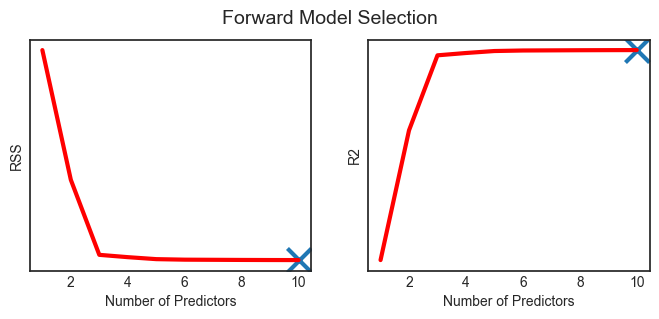

In [18]:
make_new_figure_1()

### 2.3. *Backward Stepwise Selection* (Seleção Progressiva Passo a Passo para Trás)

Assim como a **seleção passo a passo para frente**, a **seleção passo a passo para trás** oferece uma alternativa eficiente à **seleção do melhor subconjunto**.

No entanto, ao contrário da *forward selection*, a ***backward selection*** começa com o **modelo completo**, contendo **todos os $p$ preditores**, e, a partir daí, **remove iterativamente** a variável **menos útil**, uma de cada vez, até que reste apenas uma variável no modelo.

A seguir, implementamos o procedimento de **seleção progressiva passo a passo para trás** (***backward selection***), que remove uma variável de cada vez, sempre excluindo aquela cuja remoção **melhora** a função de avaliação especificada (por exemplo, a **Soma dos Quadrados dos Resíduos- RSS**):


In [19]:
def backward_selection(X, y, f):
    """
    Backward selection: remove uma variável de cada vez, excluindo a que minimiza a função f.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - f: função de avaliação do modelo (e.g., RSS).

    Retorno:
    - fms_scores: vetor com os melhores scores em cada passo.
    """
    
    # Inicializa RSS
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))

    # Variáveis categóricas
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Lista inicial com todas as variáveis
    selected_cols = list(X.columns)

    for k in range(K, 0, -1):
        temp_scores = np.zeros((0,1))

        for col in selected_cols:
            # Subset removendo uma variável
            X_subset = X.loc[:, [x for x in selected_cols if x != col]].copy()

            # Dummy encoding para categóricas
            categ_subset = list(categ_cols & set(X_subset.columns))
            if categ_subset:
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float
            X_subset = X_subset.astype(float)

            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add')

            # Regressão
            reg = OLS(y, X_reg).fit()

            # Avaliação
            temp_scores = np.append(temp_scores, f(reg))

        # Identifica a pior variável (que ao ser removida melhora a métrica)
        worst_col = selected_cols[np.argmin(temp_scores)]
        print(f"Removida: {worst_col}")

        # Remove a variável
        selected_cols.remove(worst_col)

        # Armazena o melhor score
        fms_scores[k - 1] = np.min(temp_scores)

    return fms_scores

Agora, realizamos a seleção de variáveis utilizando a Soma dos Quadrados dos Resíduos (RSS) como critério:

In [20]:
# Backward selection by RSS
rss = lambda reg : reg.ssr
bms_RSS = backward_selection(X, y, rss)

Removida: Education
Removida: Married
Removida: Gender
Removida: Ethnicity
Removida: Age
Removida: Rating
Removida: Cards
Removida: Student
Removida: Income
Removida: Limit


O algoritmo de *Backward Stepwise Selection* removeu as variáveis na ordem exibida, começando do modelo completo (com todas as variáveis) e, a cada etapa, removendo a menos útil segundo o critério escolhido — neste caso, a Soma dos Quadrados dos Resíduos (RSS).

Entre todas as variáveis presentes inicialmente, remover ***"Education"*** gerou a melhor melhoria (ou a menor piora) no modelo em termos de redução ou não aumento do RSS. ***Então, foi eliminada primeiro.***

Em seguida, repetimos o procedimento usando o coeficiente de determinação ($R^2$)

In [21]:
# Backward selection by R2
r2 = lambda reg : -reg.rsquared
bms_R2 = -backward_selection(X, y, r2)

Removida: Education
Removida: Married
Removida: Gender
Removida: Ethnicity
Removida: Age
Removida: Rating
Removida: Cards
Removida: Student
Removida: Income
Removida: Limit


Uma parte interessante dessa análise é que a variável `Rating`, que foi selecionada primeiro na seleção passo a passo para frente, agora é descartada como a quinta variável (antes da última) na *backward selection*.

Por quê?

Provavelmente porque `Rating` contém muita informação isolada (por isso foi escolhida logo no início na *forward selection*), mas está altamente correlacionada com outras variáveis, como `Student`, `Income` e `Limit`.

Como essas variáveis são mais ortogonais entre si, `Rating` acaba sendo removida antes delas na *backward selection*.

Para verificar isso, podemos observar as correlações entre essas variáveis:

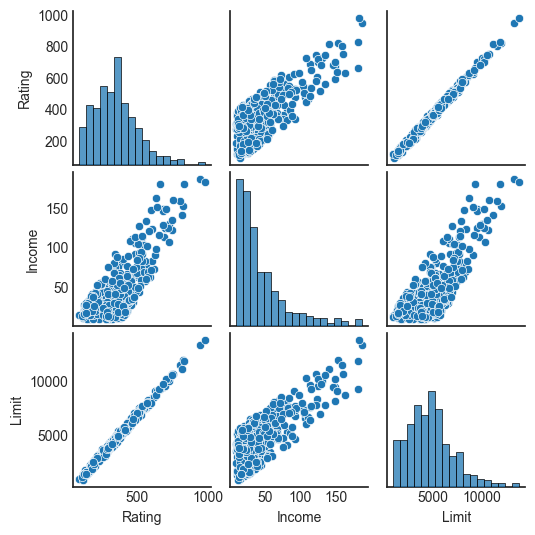

In [22]:
# Plot correlations
sns.pairplot(credit[['Rating','Student','Income','Limit']], height=1.8);

De fato, observamos que `Rating` e `Limit` são altamente correlacionados.

Por fim, vamos traçar as pontuações da *backward selection*, para diferentes números de preditores, assim como fizemos anteriormente com a forward selection.

In [23]:
# New figure 2
def make_new_figure_2():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Backward Model Selection')

    # RSS
    ax1.plot(range(1,K+1), bms_RSS, c='r');
    ax1.scatter(np.argmin(bms_RSS)+1, np.min(bms_RSS), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.plot(range(1,K+1), bms_R2, c='r');
    ax2.scatter(np.argmax(bms_R2)+1, np.max(bms_R2), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

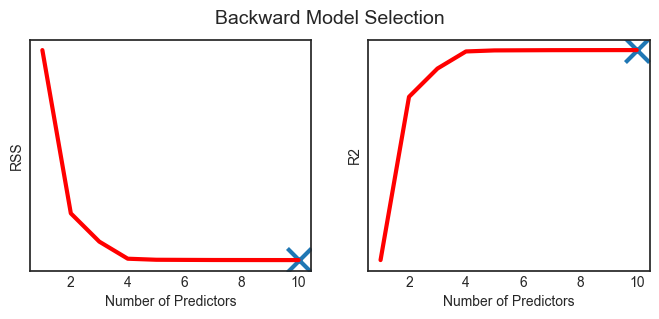

In [24]:
make_new_figure_2()

### 2.4. Escolhendo o Modelo Ideal

Até agora, utilizamos o ***erro de treinamento*** para selecionar o modelo. No entanto, o erro de treinamento pode ser uma **estimativa ruim** do ***erro de teste***.
* Erro de treinamento (training error) é o erro calculado nos mesmos dados que foram usados para ajustar o modelo.
* Erro de teste (test error) é o erro calculado em dados que **não foram usados** para ajustar o modelo, ou seja, em um conjunto de validação ou teste.

Como resultado, métricas como o **RSS** e o **$R^2$** **não são adequadas** para selecionar o melhor modelo entre um conjunto de modelos com diferentes números de preditores. Para selecionar o **melhor modelo** em relação ao **erro de teste**, precisamos **estimar** esse erro. Existem duas abordagens comuns para isso:

- Podemos **estimar indiretamente** o erro de teste, ajustando o erro de treinamento para levar em conta o **viés introduzido pelo sobreajuste** (*overfitting*).
  - Algumas métricas amplamente utilizadas que ajustam o erro de treinamento, penalizando a complexidade do modelo, são:
    - **Critério de Informação Bayesiano (BIC)**
    - **Critério de Informação de Akaike (AIC)**
    - **$R^2$ Ajustado ($R^2_{adj}$)**
- Podemos **estimar diretamente** o erro de teste utilizando um **conjunto de validação** ou uma abordagem de **validação cruzada**.

A ideia por trás de todas essas métricas é incluir uma **penalização** pelo número de parâmetros utilizados no modelo, favorecendo modelos mais **parcimoniosos**. Todas essas medidas possuem fundamentos teóricos importantes, que, no entanto, **estão além do escopo** desta aula.

Agora, vamos testar essas três métricas:

In [25]:
# Set metrics
aic = lambda reg : reg.aic
bic = lambda reg : reg.bic
r2a = lambda reg : reg.rsquared_adj

# Compute best model selection scores
scores = model_selection(X, y, aic, bic, r2a)
ms_AIC = scores[0]
ms_BIC = scores[1]
ms_R2a = scores[2]

Em seguida, extraímos os melhores valores para cada número possível de preditores:

In [26]:
# Save best scores
ms_AIC_best = [np.min(ms_AIC[ms_AIC[:,0]==k,1]) for k in range(K+1)]
ms_BIC_best = [np.min(ms_BIC[ms_BIC[:,0]==k,1]) for k in range(K+1)]
ms_R2a_best = [np.max(ms_R2a[ms_R2a[:,0]==k,1]) for k in range(K+1)]

Agora, traçamos as pontuações para os diferentes métodos de seleção de modelos, produzindo uma figura similar à Figura 6.2.

In [27]:
# Figure 6.2
def make_figure_6_2():

    # Init
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
    fig.suptitle('Figure 6.2')

    # AIC
    ax1.scatter(x=ms_AIC[:,0], y=ms_AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1),ms_AIC_best, c='r');
    ax1.scatter(np.argmin(ms_AIC_best), np.min(ms_AIC_best), marker='x', s=300)
    ax1.set_ylabel('AIC');

    # BIC
    ax2.scatter(x=ms_BIC[:,0], y=ms_BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_BIC_best, c='r');
    ax2.scatter(np.argmin(ms_BIC_best), np.min(ms_BIC_best), marker='x', s=300)
    ax2.set_ylabel('BIC');

    # R2 adj
    ax3.scatter(x=ms_R2a[:,0], y=ms_R2a[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax3.plot(range(K+1), ms_R2a_best, c='r');
    ax3.scatter(np.argmax(ms_R2a_best), np.max(ms_R2a_best), marker='x', s=300)
    ax3.set_ylabel('R2_adj');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

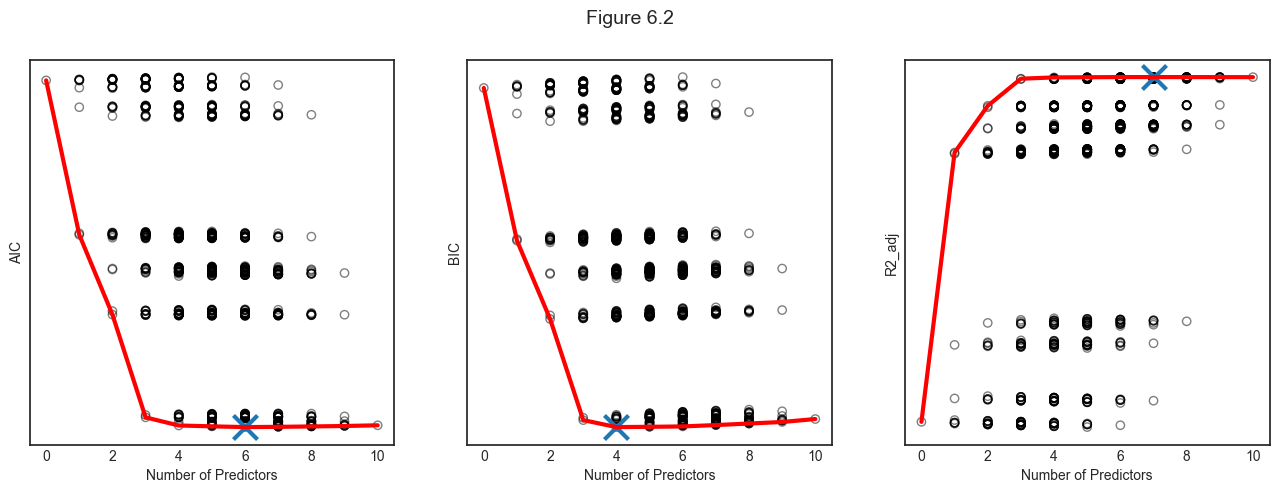

In [25]:
make_figure_6_2()

Como podemos observar, todas as três métricas tendem a selecionar modelos mais parcimoniosos, penalizando a inclusão excessiva de variáveis.

* O BIC se mostra particularmente conservador, selecionando um modelo com apenas 4 variáveis.
* O AIC, por sua vez, seleciona um modelo com 6 variáveis, que é mais complexo do que o modelo escolhido pelo BIC.
* O $R^2_{adj}$, por outro lado, seleciona um modelo maior, com 7 variáveis.

Esse comportamento está alinhado com a natureza dessas métricas: o BIC tende a penalizar mais fortemente modelos complexos do que o AIC ou o $R^2_{adj}$, favorecendo soluções mais simples.

### 2.5. Validação e Validação Cruzada

Como alternativa às abordagens discutidas anteriormente, podemos **estimar diretamente o erro de teste** utilizando o **conjunto de validação** ou os métodos de **validação cruzada** vistos anteriormente.

* A principal vantagem dessas abordagens é que elas proporcionam uma **estimativa mais realista do erro de generalização**, ao avaliar o desempenho do modelo em dados **não utilizados** durante o treinamento.
* Por outro lado, o principal **problema da validação cruzada** é a **carga computacional**: à medida que o número de partições aumenta, cresce também o número de modelos que precisam ser ajustados.

Nesta seção, realizaremos a **seleção do melhor modelo** utilizando os seguintes esquemas de validação cruzada:

- **Abordagem de conjunto de validação** com **divisão 50-50**, repetida **10 vezes**.
- **Validação cruzada** com **5 partições** (*5-fold cross-validation*).
- **Validação cruzada** com **10 partições** (*10-fold cross-validation*).

**Observação:** não realizaremos a **validação cruzada Leave-One-Out (LOOCV)** devido ao seu **alto custo computacional**, especialmente em cenários com muitos modelos potenciais.


In [28]:
def cv_scores(X, y, *args):

    # Init 
    scores = list(itertools.repeat(np.zeros((0,2)), len(args)))

    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over all possible combinations of regressions
    K = np.shape(X)[1]
    for k in range(K+1):
        print("Computing k=%1.0f" % k, end ="")
        for i in combinations(range(K), k):

            # Subset X
            X_subset = X.iloc[:,list(i)]

            # Get dummies for categorical variables
            if k>0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Metrics
            for i,cv_method in enumerate(args):
                score = cross_val_score(LinearRegression(), add_constant(X_subset), y, 
                                        cv=cv_method, scoring='neg_mean_squared_error').mean()
                score_pair = np.reshape([k,score], (1,-1))
                scores[i] = np.append(scores[i], score_pair, axis=0)
        print("", end="\r")
                
    return scores

Agora, definimos os métodos de validação cruzada e calculamos as pontuações:

In [29]:
# Define cv methods
vset = ShuffleSplit(n_splits=10, test_size=0.5)
kf5 = KFold(n_splits=5, shuffle=True)
kf10 = KFold(n_splits=10, shuffle=True)

# Get best model selection scores
scores = cv_scores(X, y, vset, kf5, kf10)
ms_vset = scores[0]
ms_kf5 = scores[1]
ms_kf10 = scores[2]

Em seguida, extraímos as melhores pontuações para cada número de preditores:

In [30]:
# Save best scores
ms_vset_best = [np.max(ms_vset[ms_vset[:,0]==k,1]) for k in range(K+1)]
ms_kf5_best = [np.max(ms_kf5[ms_kf5[:,0]==k,1]) for k in range(K+1)]
ms_kf10_best = [np.max(ms_kf10[ms_kf10[:,0]==k,1]) for k in range(K+1)]

Por fim, traçamos as pontuações obtidas para cada método de validação cruzada, gerando a Figura 6.3:

In [31]:
# Figure 6.3
def make_figure_6_3():

    # Init
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
    fig.suptitle('Figure 6.3')

    # Validation Set
    ax1.scatter(x=ms_vset[:,0], y=ms_vset[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1),ms_vset_best, c='r');
    ax1.scatter(np.argmax(ms_vset_best), np.max(ms_vset_best), marker='x', s=300)
    ax1.set_ylabel('Validation Set');


    # 5-Fold Cross Validation
    ax2.scatter(x=ms_kf5[:,0], y=ms_kf5[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_kf5_best, c='r');
    ax2.scatter(np.argmax(ms_kf5_best), np.max(ms_kf5_best), marker='x', s=300)
    ax2.set_ylabel('5-Fold Cross Validation');


    # 10-Fold Cross-Validation
    ax3.scatter(x=ms_kf10[:,0], y=ms_kf10[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax3.plot(range(K+1), ms_kf10_best, c='r');
    ax3.scatter(np.argmax(ms_kf10_best), np.max(ms_kf10_best), marker='x', s=300)
    ax3.set_ylabel('10-Fold Cross-Validation');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

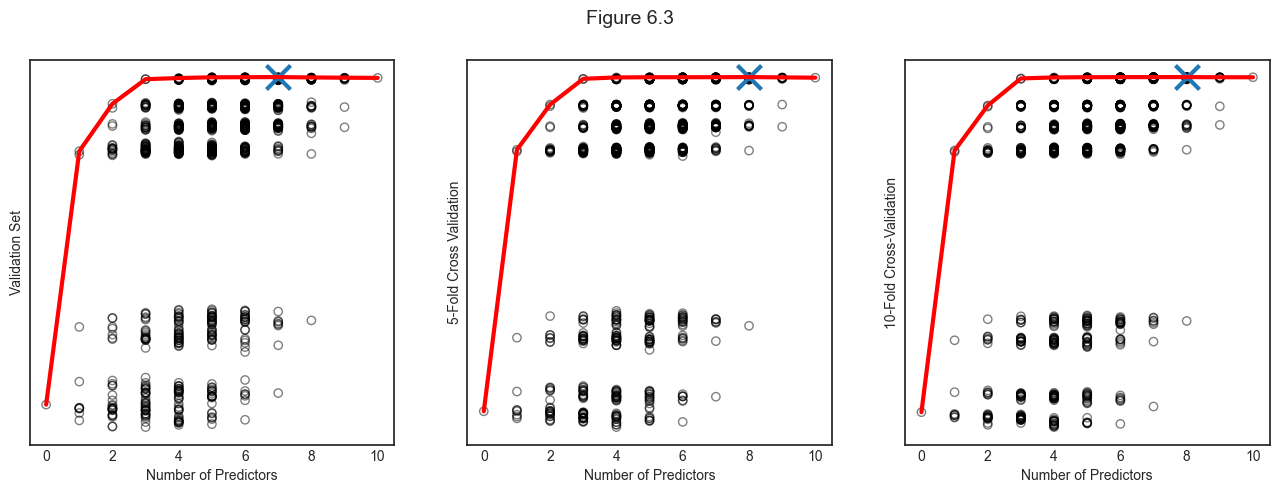

In [32]:
make_figure_6_3()

Na figura, observamos que **cada método de validação cruzada seleciona um modelo diferente**. O mais preciso, a **validação cruzada K-fold**, seleciona um modelo com **7 preditores** (no caso do **5-fold**) e **8 preditores** (no caso do **10-fold**).

OBS: não fixei a semente aleatória, então os resultados podem variar a cada execução.

### 3. *Shrinkage Methods* (Métodos de Encolhimento)

Até aqui, vimos que os métodos de seleção de modelos atuam escolhendo subconjuntos de variáveis após a estimação das regressões lineares. Esse processo pode ser computacionalmente custoso, especialmente quando o número de preditores é grande.

Por outro lado, os métodos de encolhimento (*shrinkage methods*) buscam ajustar o modelo e controlar sua complexidade simultaneamente. Eles fazem isso ao impor penalidades na função objetivo da regressão, de modo a restringir ou reduzir os valores estimados dos coeficientes $\beta$ . Como resultado, esses métodos tendem a produzir estimativas mais estáveis, particularmente em situações com alta multicolinearidade ou número elevado de variáveis explicativas.

### 3.1. *Ridge Regression* (Regressão Ridge)

Na regressão clássica de OLS, buscamos os coeficientes $\hat{\beta}$ que **minimizam** a **Soma dos Quadrados dos Resíduos** (**RSS** ou *Residual Sum of Squares*):

$$ 
\hat{\beta}^{OLS} = \underset{\beta}{\operatorname{argmin}} \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 = \underset{\beta}{\operatorname{argmin}} RSS
$$

Na **regressão de Ridge**, a função objetivo é **modificada** com a inclusão de uma **penalidade quadrática** sobre os coeficientes (exceto o intercepto $\beta_0$):

$$
\hat{\beta}^{Ridge} = \underset{\beta}{\operatorname{argmin}} \left\{ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right\} 
$$

De forma compacta usando notação vetorial, a penalização é expressa como norma ($L2$: norma euclidiana) :
$$
\hat{\beta}^{Ridge} = \underset{\beta}{\operatorname{argmin}} (RSS + \lambda ||\beta||^{2}_{2})
$$

onde $||\beta||^{2}_{2} = \sum_{j=1}^{p} \beta_j^2$ é a norma $L2$ dos coeficientes ao quadrado, e $\lambda > 0$ é um **parâmetro de ajuste (ou hiperparâmetro)** que controla o grau de penalização: quanto maior $\lambda$, mais os coeficientes são **encolhidos** em direção a zero. 

Mas por quê? Vejamos na **notação matricial** (após realizar a CPO e igualar a zero), o problema equivale a:

$$ \hat{\beta}^{Ridge} = \left( X^\top X + \lambda I \right)^{-1} X^\top y $$

considerando $var(\epsilon) = \sigma^2 I$. A variância dos estimadores Ridge (para os $\beta_{j}$, não o intercepto) é dada por:

$$
Var(\hat{\beta}^{Ridge}) = \sigma^2 (X^\top X + \lambda I)^{-1} X^\top X (X^\top X + \lambda I)^{-1} 
$$


E essa formulação matricial deixa evidente que a regressão de Ridge é uma **extensão natural** do OLS, que busca um **equilíbrio** entre **minimizar o erro** de ajuste e **controlar a magnitude dos coeficientes**:

* Por um lado, queremos minimizar o erro (RSS), para que o modelo explique bem os dados.
* Por outro lado, queremos evitar coeficientes muito grandes, que podem causar *overfitting* ou instabilidade (especialmente quando há multicolinearidade).

Ridge cria esse equilíbrio:
* Se $\lambda = 0$, temos OLS puro: foco total em minimizar o erro.
* Se $\lambda$ muito grande, os coeficientes são fortemente encolhidos para zero, priorizando a simplicidade e estabilidade, mesmo que o erro aumente um pouco.

Agora, executaremos a **regressão de Ridge** no conjunto de dados `credit`, tentando explicar a variável **`Balance`** com um conjunto de **características individuais observáveis**.


In [33]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

Executamos a **regressão de Ridge** em uma faixa de valores para o parâmetro de penalidade $\lambda$.


In [34]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

Em seguida, utilizamos a regressão linear como comparação:

In [35]:
# OLS regression
ols = LinearRegression().fit(scale(X),y)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

Agora, plotamos os resultados:

In [36]:
# Figure 6.4
def make_figure_6_4():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.4: Ridge Regression Coefficients')

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax1.plot(alphas, ridge_coefs[:,highlight], alpha=1)
    ax1.plot(alphas, ridge_coefs, c='grey', alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
    ax1.legend(['Income', 'Limit', 'Rating', 'Student'])

    # Plot coefficients - relative
    ax2.plot(rel_beta, ridge_coefs[:,highlight], alpha=1)
    ax2.plot(rel_beta, ridge_coefs, c='grey', alpha=0.3)
    ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');

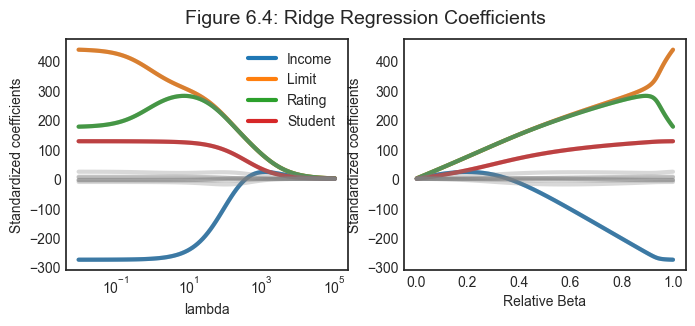

In [37]:
make_figure_6_4()

À medida que diminuímos o valor de $\lambda$, os coeficientes da regressão de Ridge aumentam em magnitude, aproximando-se dos coeficientes obtidos pela regressão linear clássica.

Além disso, observamos que as variáveis com os coeficientes consistentemente maiores (em termos de magnitude) são:

* Income
* Limit
* Rating
* Student

Esse comportamento destaca como a penalização afeta os coeficientes, reduzindo sua magnitude conforme $\lambda$ aumenta e controlando o sobreajuste ao restringir a complexidade do modelo.

### 3.2. *Trade-off* entre Viés e Variância

A principal vantagem da **regressão de Ridge** em relação aos **mínimos quadrados ordinários (OLS)** está no controle do *trade-off* entre **viés** e **variância** do estimador.

À medida que o **parâmetro de penalização** $\lambda$ **aumenta**, a **flexibilidade** do modelo diminui. Isso leva a uma **redução da variância**, mas também a um **aumento do viés**.

A relação fundamental pode ser expressa pelo modelo:

$$
y_i = f(x_i) + \varepsilon, \quad \text{com} \quad \mathbb{E}[\varepsilon] = 0, \quad \text{Var}(\varepsilon) = \sigma^2
$$

O **Erro Quadrático Médio** (MSE - *Mean Squared Error*) de um estimador $\hat{f}(x_i)$ para um ponto $x_i$ pode ser decomposto como:

$$
\mathbb{E}\left[(y_i - \hat{f}(x_i))^2\right] = 
\underbrace{\left(\mathbb{E}[\hat{f}(x_i)] - f(x_i)\right)^2}_{\text{Viés}^2} + 
\underbrace{\text{Var}[\hat{f}(x_i)]}_{\text{Variância}} + 
\underbrace{\sigma^2}_{\text{Erro Irredutível}}
$$

Passos intermediários:

$$ E[(y_i - \hat{f}(x_i))^2] = E[(f(x_i) + \varepsilon_i - \hat{f}(x_i))^2] $$

$$ = E[(f(x_i) - \hat{f}(x_i) + \varepsilon_i)^2] $$

$$ = E[(f(x_i) - \hat{f}(x_i))^2 + 2(f(x_i) - \hat{f}(x_i))\varepsilon_i + \varepsilon_i^2] $$

$$ = E[(f(x_i) - \hat{f}(x_i))^2] + 2E[(f(x_i) - \hat{f}(x_i))\varepsilon_i] + E[\varepsilon_i^2] $$

Como $\mathbb{E}[\varepsilon_i] = 0$, o termo cruzado desaparece:

$$ = E[(f(x_i) - \hat{f}(x_i))^2] + \sigma^2 $$ 

Por fim, decomponha o primeiro termo (que representa o erro médio entre a predição e o valor verdadeiro); A ideia é separar esse erro em duas partes:
* Um erro sistemático: o quanto o valor médio de $\hat{f}(x_i)$ se afasta do valor verdadeiro $f(x_i)$ → isso é o viés.
* Um erro aleatório: o quanto a predição $\hat{f}(x_i)$ varia em torno do seu valor médio → isso é a variância.

Usando a identidade de viés e variância:

$$ E[(f(x_i) - \hat{f}(x_i))^2] = \left(\mathbb{E}[\hat{f}(x_i)] - f(x_i)\right)^2 + \text{Var}[\hat{f}(x_i)] $$

Ou seja, decompomos *MSE* como:

$$
\mathrm{MSE}(x_i) = \text{Bias}^2[\hat{f}(x_i)] + \text{Var}[\hat{f}(x_i)] + \sigma^2
$$

Essa decomposição revela que o **Erro Quadrático Médio** (MSE) possui três componentes fundamentais:
- **Viés ao quadrado**, que captura a rigidez ou subajuste do modelo.
- **Variância**, que reflete a instabilidade das estimativas em diferentes amostras.
- **Erro irredutível**, que representa o ruído intrínseco nos dados.

Como veremos nos experimentos a seguir, ao aumentar $\lambda$, conseguimos **reduzir a variância**, mas com o custo de um **aumento no viés**. A regressão de Ridge busca **minimizar o MSE** encontrando um ponto ótimo nesse *trade-off*.

In [38]:
# Compute var-bias
def compute_var_bias(X_train, b0, x0, a, k, n, sim, f):
    
    # Init 
    y_hat = np.zeros(sim)
    coefs = np.zeros((sim, k))
    
    # Loop over simulations
    for s in range(sim):
        e_train = normal(0,1,(n,1))
        y_train = X_train @ b0 + e_train
        fit = f(a).fit(X_train, y_train)
        y_hat[s] = fit.predict(x0)
        coefs[s,:] = fit.coef_
        
    # Compute MSE, Var and Bias2   
    e_test = normal(0,1,(sim,1))
    y_test = x0 @ b0 + e_test
    mse = np.mean((y_test - y_hat)**2)
    var = np.var(y_hat)
    bias2 = np.mean(x0 @ b0 - y_hat)**2
    
    return [mse, var, bias2], np.mean(coefs, axis=0)

Agora, geramos dados sintéticos para simular esse comportamento:

In [39]:
np.random.seed(1)

# Generate random data
n = 50
k = 45
N = 50000
X_train = normal(0.2,1,(n,k))
x0 = normal(0.2,1,(1,k))
e_train = normal(0,1,(n,1))
b0 = uniform(0,1,(k,1))

In [40]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-5,5,n_grid)})
ridge_coefs2 = []

# Init simulations
sim = 1000
ridge = lambda a: Ridge(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, ridge)
    ridge_coefs2.append(c)
    print("", end="\r")
ridge_coefs2 = np.reshape(ridge_coefs2,(n_grid,-1))

OBS: O $\alpha$ no `scikit-learn` é igual ao $\lambda$ na teoria.

Em seguida, comparamos com a regressão OLS:

In [41]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs2[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

Por fim, plotamos a decomposição do viés e variância:

In [42]:
# Figure 6.5
def make_figure_6_5():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.5: Ridge Bias-Var decomposition')

    # MSE
    ax1.plot(df['alpha'], df[['bias2','var','mse']]);
    ax1.set_xscale('log');
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
    ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

    # MSE
    ax2.plot(rel_beta, df[['bias2','var','mse']]);
    ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Mean Squared Error');
    ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

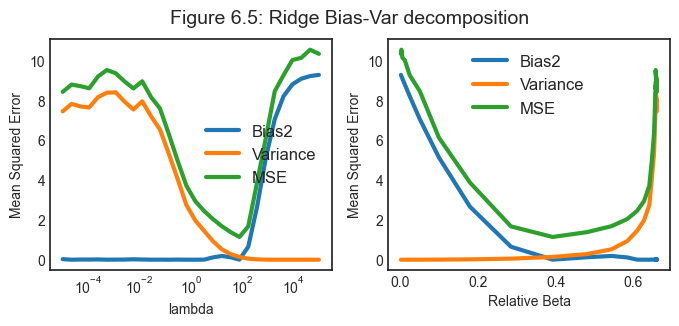

In [43]:
make_figure_6_5()

A Figura 6.5 apresenta a decomposição do **erro quadrático médio (EQM/MSE)** em **viés ao quadrado** e **variância** para diferentes valores do parâmetro de penalização $\lambda$ na regressão de Ridge.

No **gráfico da esquerda**, com o eixo X em escala logarítmica para $\lambda$, observamos:

- Para **valores pequenos de $\lambda$**, o modelo é muito flexível, resultando em **baixa bias** (viés ao quadrado próximo de zero), mas **alta variância**. Esse é o típico comportamento de um modelo **superajustado** (*overfitted*).
- À medida que $\lambda$ **aumenta**, os coeficientes são **encolhidos**, a **variância do estimador diminui**, mas o **viés aumenta**.
- Existe um **ponto ótimo** (em torno de $\lambda \approx 10$), onde o **MSE é minimizado**. Nesse ponto, o modelo alcança o **melhor equilíbrio entre viés e variância**.
- Para **valores muito altos de $\lambda$**, o modelo é excessivamente penalizado, os coeficientes são fortemente encolhidos, o **viés domina**, e o erro total volta a crescer.

No **gráfico da direita**, o eixo X mostra a **norma relativa dos coeficientes** estimados pela regressão de Ridge em relação à norma dos coeficientes do OLS:

$$ \text{Norma Relativa} = \frac{||\hat{\beta}^{Ridge}||_2}{||\hat{\beta}^{OLS}||_2} = \frac{\sqrt{\sum_{j=1}^{p} \hat{\beta}_j^{Ridge 2}}}{\sqrt{\sum_{j=1}^{p} \hat{\beta}_j^{OLS 2}}} $$


- Quando os coeficientes estão próximos de zero (**baixa complexidade**) então o Ridge penaliza fortemente os coeficientes, resultando em um **viés alto** e uma **variância baixa**.
- Quando os coeficientes se aproximam dos valores do OLS (**alta complexidade**), a **variância aumenta** e o **viés diminui**.
- Novamente, o **ponto de menor MSE** ocorre em um ponto intermediário, sugerindo que a **melhor performance preditiva** não ocorre nos extremos, mas no meio do caminho entre **simplicidade e flexibilidade**.

Essa simulação reforça a ideia central de que a regressão de Ridge **melhora a generalização** do modelo ao introduzir um **viés controlado** para **reduzir a variância** — especialmente em contextos com **alta dimensionalidade** e **multicolinearidade**.



A regressão de Ridge tende a incluir todos os $p$ preditores no modelo final, embora com coeficientes reduzidos.

O Lasso resolve essa questão ao usar uma função de penalidade diferente, que força alguns coeficientes a serem exatamente iguais a zero, promovendo assim a seleção de variáveis de maneira automática.

### 3.3. Lasso (*Least Absolute Shrinkage and Selection Operator*)

Os coeficientes do **Lasso** (*Operador de Encolhimento Absoluto Mínimo e Seleção de Variáveis*) são obtidos minimizando a seguinte **função objetivo**:

$$
\hat{\beta}^{Lasso} = \underset{\beta}{\operatorname{argmin}} \left\{ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}
$$

A principal diferença em relação à **regressão de Ridge** está na forma da **penalização**: enquanto Ridge impõe uma penalidade quadrática sobre os coeficientes (norma $\ell_2$), o Lasso utiliza a **norma $\ell_1$**, ou seja, penaliza a soma dos valores absolutos dos coeficientes.

Essa distinção possui uma **implicação fundamental**: o Lasso tende a **forçar muitos coeficientes a exatamente zero**, realizando assim uma **seleção automática de variáveis**. Por outro lado, a regressão de Ridge apenas reduz a magnitude dos coeficientes, mas não os anula completamente.

Sob algumas condições específicas:

- Se as variáveis explicativas são **padronizadas** (média zero e variância unitária),
- Se o modelo não possuir intercepto,
- E se a **colinearidade entre os preditores for baixa**,

a solução do Lasso pode ser **aproximada** por:

$$
\hat{\beta}^{Lasso}_{j} \approx \hat{\beta}^{OLS}_{j} - \frac{\lambda}{2} [(X^\top X)^{-1}]_{j}.\operatorname{sign}(\hat{\beta}^{Lasso}_{j})
$$


Essa expressão é uma **aproximação heurística** que visa fornecer **intuição** sobre o impacto da penalização $\ell_1$, mas **não deve ser utilizada para fins computacionais ou teóricos formais**. Diferentemente da regressão de Ridge, o Lasso **não possui solução analítica fechada**. Sua estimação depende de **métodos numéricos iterativos**, como, por exemplo, ***Métodos baseados em gradiente***, como subgradientes ou métodos de otimização convexa.

Mas podemos perceber que o $\beta_{OLS}$ será zerado quando $\lambda$ for suficientemente grande, ou seja, o Lasso pode levar a uma solução onde alguns coeficientes são exatamente zero, enquanto outros são ajustados de forma semelhante ao OLS.


A seguir, aplicaremos o Lasso ao conjunto de dados `credit`, comparando os coeficientes obtidos com os do Ridge e do OLS.


In [44]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']

A grade do $\lambda$ será um pouco diferente agora.

In [45]:
# Init alpha grid
n_grid = 100
alphas = 10 ** np.linspace(0, 3, n_grid)  # Sem reshape

lasso = Lasso(max_iter=10000)  # Garantia de convergência
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.reshape(lasso_coefs, (n_grid, -1))

Executamos o OLS para traçar a magnitude relativa dos coeficientes do Lasso.

In [46]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

Traçamos a magnitude dos coeficientes $\beta$ 
* para diferentes valores de $\lambda$.
* para diferentes valores de $|\beta|$.

In [47]:
# Figure 6.6
def make_figure_6_6():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.6')

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
    ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
    ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

    # Plot coefficients - relative
    ax2.plot(rel_beta, lasso_coefs[:,highlight], alpha=1)
    ax2.plot(rel_beta, lasso_coefs, c='grey', alpha=0.3)
    ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');

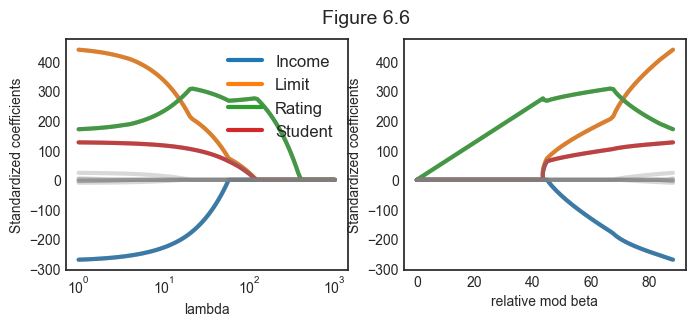

In [48]:
make_figure_6_6()

A Figura 6.6 ilustra a trajetória dos coeficientes estimados pelo Lasso à medida que o parâmetro de penalização $\lambda$ varia. Observa-se que:

- À medida que $\lambda$ aumenta, os coeficientes são progressivamente encolhidos em direção a zero.
- Diferentemente do Ridge, a penalização $\ell_1$ do Lasso tem o efeito de forçar **alguns coeficientes a zero exatamente**, realizando uma **seleção automática de variáveis**.
- Por exemplo, `Rating` se destaca como uma das variáveis mais persistentes, mantendo um valor distinto de zero mesmo sob penalizações mais intensas, enquanto outras variáveis são eliminadas conforme $\lambda$ cresce.

Assim como os métodos de seleção de subconjunto, o Lasso produz modelos **esparsos** — ou seja, modelos que utilizam apenas um subconjunto das variáveis explicativas. Essa característica é especialmente útil em situações com **muitos preditores**, onde é desejável um modelo mais interpretável e robusto.

A seguir, exploraremos como a escolha de $\lambda$ afeta o **trade-off entre viés e variância** no Lasso, de forma análoga ao que foi feito para o Ridge.


In [49]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
lasso_coefs2 = []

# Init simulations
sim = 1000
lasso = lambda a: Lasso(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, lasso)
    lasso_coefs2.append(c)
    print("", end="\r")
lasso_coefs2 = np.reshape(lasso_coefs2,(n_grid,-1))

In [50]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs2[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [51]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs2[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [52]:
# Figure 6.8
def make_figure_6_8():

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Figure 6.8: Lasso Bias-Var decomposition')

    # MSE
    ax1.plot(df['alpha'], df[['bias2','var','mse']]);
    ax1.set_xscale('log');
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
    ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

    # MSE
    ax2.plot(rel_beta, df[['bias2','var','mse']]);
    ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
    ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

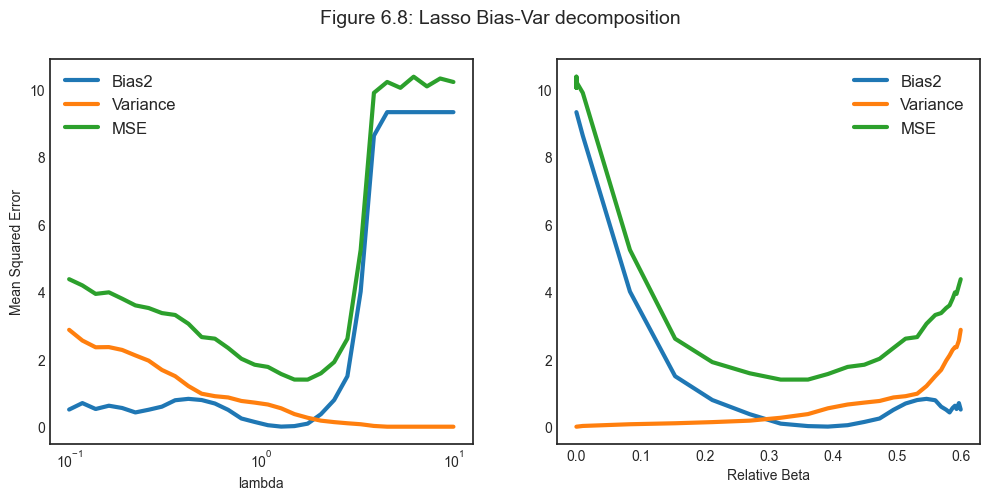

In [51]:
make_figure_6_8()

A Figura 6.8 apresenta a decomposição do **erro quadrático médio (MSE)** em função do parâmetro de penalização $\lambda$, utilizando simulações para o estimador Lasso.

No painel à esquerda, com o eixo $x$ representando os valores de $\lambda$ em escala logarítmica, observa-se que:

- À medida que $\lambda$ **aumenta**, a penalização $\ell_1$ se intensifica.
- Como consequência, o **viés ao quadrado (Bias²)** aumenta, já que os coeficientes são forçados a valores menores ou até zero.
- Em contrapartida, a **variância** do estimador diminui, pois o modelo se torna menos sensível a variações nos dados.
- Existe um valor intermediário de $\lambda$ que **minimiza o MSE**, representando o ponto ótimo do *trade-off* entre viés e variância.

O painel à direita apresenta os mesmos componentes do MSE, mas agora em função da **norma relativa dos coeficientes estimados** em relação à regressão OLS. À medida que os coeficientes se tornam menores (menor complexidade do modelo), o viés aumenta, e a variância diminui.

Esses resultados mostram que o Lasso, assim como o Ridge, busca reduzir o erro de predição total por meio da **penalização da complexidade**. Entretanto, o Lasso possui a vantagem adicional de **realizar seleção de variáveis**, promovendo modelos mais **esparsos e interpretáveis**.


### 3.4. Comparando a Regressão Lasso e Ridge

Para obter uma melhor **intuição geométrica e algébrica** sobre o comportamento da **regressão de Ridge** e do **Lasso**, considere o seguinte **caso especial simplificado**:

- O número de observações é igual ao número de preditores: $n = p$;
- A matriz de regressão $X$ é a **matriz identidade**, ou seja, uma matriz diagonal com 1 na diagonal e 0 fora;
- O modelo não inclui termo de intercepto.

Com essas simplificações, o problema de **mínimos quadrados ordinários (OLS)** se reduz à minimização:

$$
\sum_{j=1}^{p} (y_{j} - \beta_{j})^{2}
$$

cuja solução é simplesmente:

$$
\hat{\beta}_{j}^{OLS} = y_j
$$

Contudo, ao introduzirmos penalizações, as soluções estimadas se modificam:

***Regressão de Ridge***

A solução para o Ridge torna-se:

$$
\hat{\beta}_{j}^{Ridge} = \frac{y_j}{1 + \lambda}
$$

Ou seja, cada coeficiente é **encolhido proporcionalmente** à penalização $\lambda$, sem jamais atingir exatamente zero.

***Regressão Lasso***

Para o Lasso, a solução adota a forma da **função de soft-thresholding**:

$$
\hat{\beta}_{j}^{Lasso} = 
\begin{cases}
y_j - \lambda/2 & \text{se } y_j > \lambda/2 \\\\
y_j + \lambda/2 & \text{se } y_j < -\lambda/2 \\\\
0 & \text{se } |y_j| \leq \lambda/2
\end{cases}
$$

Dessa forma, o Lasso **reduz a magnitude** dos coeficientes, mas, diferentemente do Ridge, ele também **zera exatamente** aqueles que estão abaixo de certo limiar — promovendo assim **esparsidade** no vetor de parâmetros.


In [53]:
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = normal(0,1,(n,1))
b0 = uniform(-1,1,(k,1))
y = X @ b0 + e

In [54]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

In [55]:
# Figure 6.10
def make_figure_6_10():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.10')

    # Ridge
    ax1.plot(y_sorted.T, ols_coefs.T)
    ax1.plot(y_sorted.T, ridge_coefs.T)
    ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
    ax1.legend(['OLS','Ridge'], fontsize=12);

    # Lasso
    ax2.plot(y_sorted.T, ols_coefs.T)
    ax2.plot(y_sorted.T, lasso_coefs.T)
    ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
    ax2.legend(['OLS','Lasso'], fontsize=12);

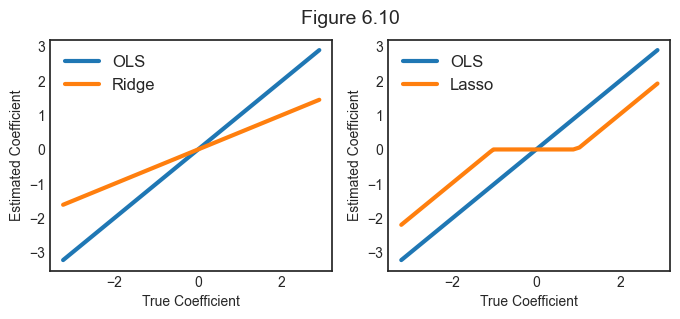

In [56]:
make_figure_6_10()

Vemos que a regressão Ridge reduz todas as dimensões dos dados na mesma proporção, enquanto o LASSO reduz todos os coeficientes em direção a zero em uma quantidade similar, e coeficientes suficientemente pequenos são reduzidos até zero.

### 3.5. Selecionando o Parâmetro de Ajuste (Hiperparâmetro) $\lambda$

A implementação da **regressão de Ridge** e do **Lasso** requer um método para selecionar um valor apropriado para o **parâmetro de ajuste** $\lambda$.

A **validação cruzada** oferece uma maneira simples e eficaz de resolver esse problema. O procedimento geral consiste em:

1. Escolher uma **grade de valores** para o parâmetro $\lambda$;
2. Para cada valor de $\lambda$, calcular o **erro de validação cruzada** correspondente;
3. Selecionar o valor de $\lambda$ que **minimiza** o **erro de validação cruzada**;
4. Por fim, com o **parâmetro selecionado**, o modelo é **reajustado** utilizando **todas as observações disponíveis**, garantindo que o ajuste final se beneficie de toda a informação amostral.

Esse procedimento permite equilibrar adequadamente a **complexidade do modelo** e o **erro de generalização**, evitando tanto o **sobreajuste** (quando $\lambda$ é pequeno) quanto o **subajuste** (quando $\lambda$ é excessivamente grande).


In [57]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

Usaremos o CV de 10 vezes como algoritmo de validação cruzada.

In [58]:
def cv_lasso(X, y, a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lasso = Lasso(alpha=a, max_iter=10000).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    
    return np.mean(mse)

In [59]:
# Compute MSE over grid of alphas
n_grid = 30
alphas = 10 ** np.linspace(0, 3, n_grid)  # CORRETO: shape (30,)

MSE = [cv_lasso(scale(X), y.values, a) for a in alphas]

Qual é o $\lambda$ ideal?

In [60]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by 10fold CV:',alpha_min)

Best alpha by 10fold CV: 1.0


Agora plotamos a função objetivo e os coeficientes implícitos $\lambda$ no ponto ótimo.

In [61]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso = Lasso(alpha=a).fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [62]:
# Figure 6.12
def make_figure_6_12():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.12: Lasso 10-fold CV')

    # MSE by LOO CV
    ax1.plot(alphas, MSE, alpha=1);
    ax1.axvline(alpha_min, c='k', ls='--')
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax2.plot(alphas, coefs[:,highlight], alpha=1)
    ax2.plot(alphas, coefs, c='grey', alpha=0.3)
    ax2.axvline(alpha_min, c='k', ls='--')
    ax2.set_xscale('log')
    ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
    ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);

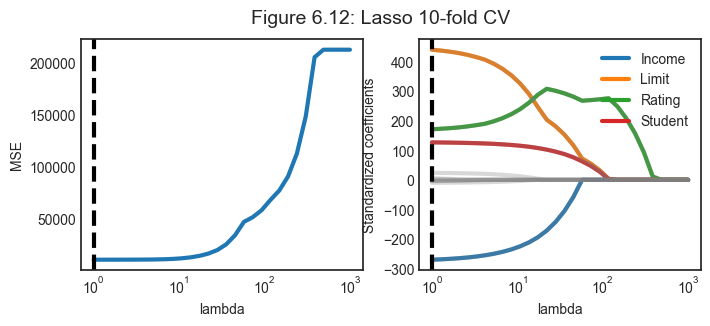

In [63]:
make_figure_6_12()

### 3.5. Elastic Net

O **Elastic Net** combina os benefícios da regressão **Ridge** e do **Lasso**. Ele é particularmente útil quando há **alta correlação entre variáveis explicativas**, situação na qual o Lasso pode se tornar instável.

A função objetivo do Elastic Net é:

$$
\hat{\beta}^{EN} = \underset{\beta}{\operatorname{argmin}} \left\{
\| y - X\beta \|_2^2 + \lambda \left( \alpha \|\beta\|_1 + \frac{1 - \alpha}{2} \|\beta\|_2^2 \right)
\right\}
$$

onde:
- $\lambda \geq 0$ controla o grau total de penalização;
- $\alpha \in [0, 1]$ determina o peso relativo entre Lasso e Ridge:
  - $\alpha = 1$: solução do Lasso;
  - $\alpha = 0$: solução do Ridge;
  - $0 < \alpha < 1$: interpolação entre os dois.


### Intuição

- A penalização $\ell_1$ favorece **esparsidade** (seleção de variáveis);
- A penalização $\ell_2$ estabiliza as estimativas em presença de **colinearidade**;
- O Elastic Net tende a **selecionar grupos de variáveis correlacionadas**, ao contrário do Lasso, que pode selecionar apenas uma.

Esse método oferece uma flexibilidade entre Ridge e Lasso.


### Como escolher na prática?

Use validação cruzada para comparar:
* Ajuste Ridge e Lasso com grid de $\lambda$
* Ajuste Elastic Net com grid de $\alpha$ e $\lambda$ (mistura entre L1 e L2)
* Compare os erros de validação cruzada
* Escolha o modelo com menor erro.

### Seleção de Variáveis Clássica vs Regularização

A principal diferença entre os métodos de **seleção de variáveis clássica** (como *forward selection*, *backward selection* e *best subset selection*) e os métodos de **regularização** (como Ridge, Lasso e Elastic Net) está na forma como lidam com a **complexidade do modelo** e a **seleção de preditores**.

Os métodos de **regularização** tendem a ser superiores em termos de **precisão preditiva** e **robustez** quando:

- O número de variáveis é grande.
- Existe multicolinearidade entre os preditores.
- O contexto é de **alta dimensionalidade** (inclusive $ p > n $).
- O objetivo principal é a **generalização fora da amostra**.
- O foco está em **minimizar o erro de predição**, e não apenas em interpretar os coeficientes.

Já os métodos de **seleção de variáveis clássica** são mais apropriados quando:

- O número de variáveis é pequeno ou moderado.
- O modelo precisa ser **interpretável e explicativo**, com base em significância estatística.
- A multicolinearidade não é um problema importante.
- O foco está em **identificar variáveis relevantes** para o fenômeno estudado, mais do que na performance preditiva.

**Observação:** entre os métodos de regularização, o **Lasso** e o **Elastic Net** também realizam **seleção de variáveis** — zerando coeficientes — e, por isso, **podem ser interpretáveis** quando bem ajustados.
